<a href="https://colab.research.google.com/github/tinybeachthor/ucboulder-ml-supervised/blob/main/model_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UCBoulder Supervised Machine Learning final project

### Questions

- What does a popular song sound like?
- Can we predict the success of a song?

### Data
- Billboard 100 song rankings between years 2010 and 2020
- Spotify audio features for all the songs

In [2]:
# dependencies imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Load data

Data cleaning and merging done in another notebook:
https://github.com/tinybeachthor/ucboulder-ml-supervised/blob/main/data.ipynb

Load the prepared data here.

Data:
- song name and artist
- highest, lowest billboard position
- weeks on billboard chart
- song audio features (energy, speechiness, liveness, ...)
- song metadata (song length, key, mode, ...)

In [3]:
!wget https://raw.githubusercontent.com/tinybeachthor/ucboulder-ml-supervised/main/data/billboard_2010s.csv

--2024-04-29 19:36:39--  https://raw.githubusercontent.com/tinybeachthor/ucboulder-ml-supervised/main/data/billboard_2010s.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 825815 (806K) [text/plain]
Saving to: ‘billboard_2010s.csv’

billboard_2010s.csv 100%[===================>] 806.46K  5.08MB/s    in 0.2s    

2024-04-29 19:36:39 (5.08 MB/s) - ‘billboard_2010s.csv’ saved [825815/825815]



In [4]:
df = pd.read_csv('billboard_2010s.csv')
df = df.dropna()
print(df.shape)
print(df.columns)

features_numeric = list(df.select_dtypes(include=['int', 'float']).columns)
print(features_numeric)

df.head()

(4425, 22)
Index(['song_id', 'song', 'performer', 'first_week_on_chart',
       'last_week_on_chart', 'weeks_on_chart', 'highest_position',
       'lowest_position', 'spotify_track_duration_ms',
       'spotify_track_explicit', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')
['weeks_on_chart', 'highest_position', 'lowest_position', 'spotify_track_duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


,song_id,song,performer,first_week_on_chart,last_week_on_chart,weeks_on_chart,highest_position,lowest_position,spotify_track_duration_ms,spotify_track_explicit,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,#BeautifulMariah Carey Featuring Miguel,#Beautiful,Mariah Carey Featuring Miguel,2013-05-25,2013-09-07,16,15,95,199866.0,False,...,4.0,-5.405,1.0,0.0391,0.34600,0.000000,0.3470,0.469,107.042,4.0
1,#SELFIEThe Chainsmokers,#SELFIE,The Chainsmokers,2014-03-15,2014-05-24,11,16,95,183750.0,False,...,0.0,-3.282,1.0,0.2260,0.01340,0.000012,0.0787,0.651,127.973,4.0
2,#thatPOWERwill.i.am Featuring Justin Bieber,#thatPOWER,will.i.am Featuring Justin Bieber,2013-04-06,2013-07-20,16,17,85,279506.0,False,...,6.0,-6.096,0.0,0.0583,0.00112,0.000077,0.0748,0.403,128.000,4.0
3,$ave Dat MoneyLil Dicky Featuring Fetty Wap & ...,$ave Dat Money,Lil Dicky Featuring Fetty Wap & Rich Homie Quan,2015-10-10,2016-03-19,19,71,100,290835.0,True,...,2.0,-5.361,1.0,0.2300,0.11400,0.000000,0.2240,0.364,98.012,4.0
4,'Til Summer Comes AroundKeith Urban,'Til Summer Comes Around,Keith Urban,2010-01-30,2010-05-15,16,58,94,331466.0,False,...,9.0,-7.608,0.0,0.0331,0.59300,0.000136,0.7700,0.308,127.907,4.0


## Explore

Explore the data features.

<Axes: ylabel='Frequency'>

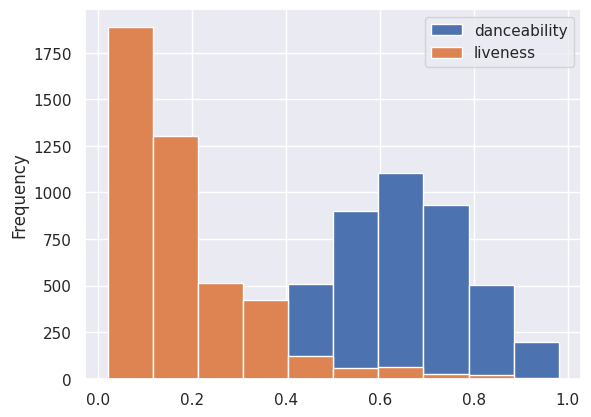

In [10]:
df[['danceability', 'liveness']].plot.hist()

<Axes: ylabel='Frequency'>

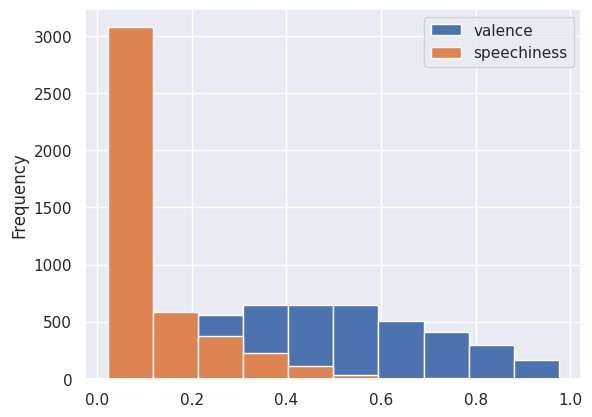

In [11]:
df[['valence', 'speechiness']].plot.hist()

### Correlations

Plot correlation heatmap for all the features.

- strong correlation between `weeks_on_chart` and `position`
- weak correlations of audio features
- some high correlations between features `energy` vs `loudness` (check colinearity)

<Axes: >

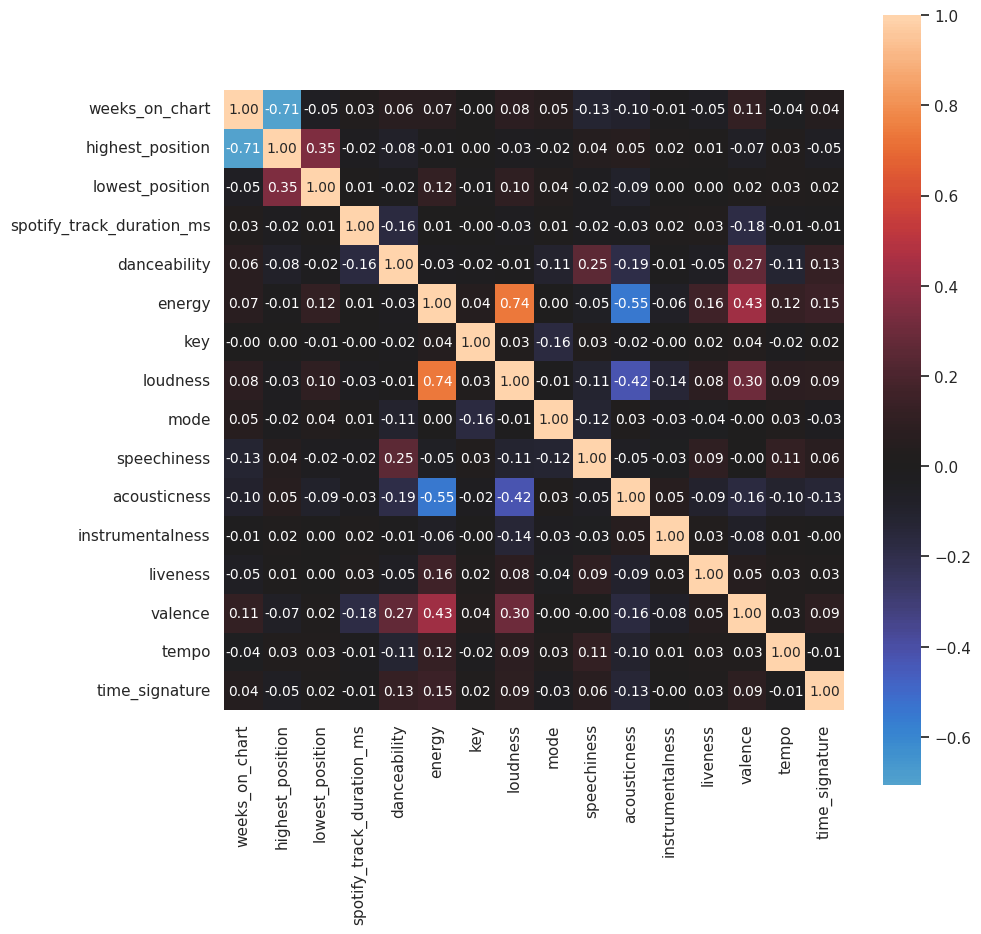

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(df[features_numeric].corr(),
            annot=True, square=True, center=0.0, fmt=".2f", annot_kws={"size": 10})

### Check colinearity of high-correlation features

<Figure size 1000x1000 with 0 Axes>

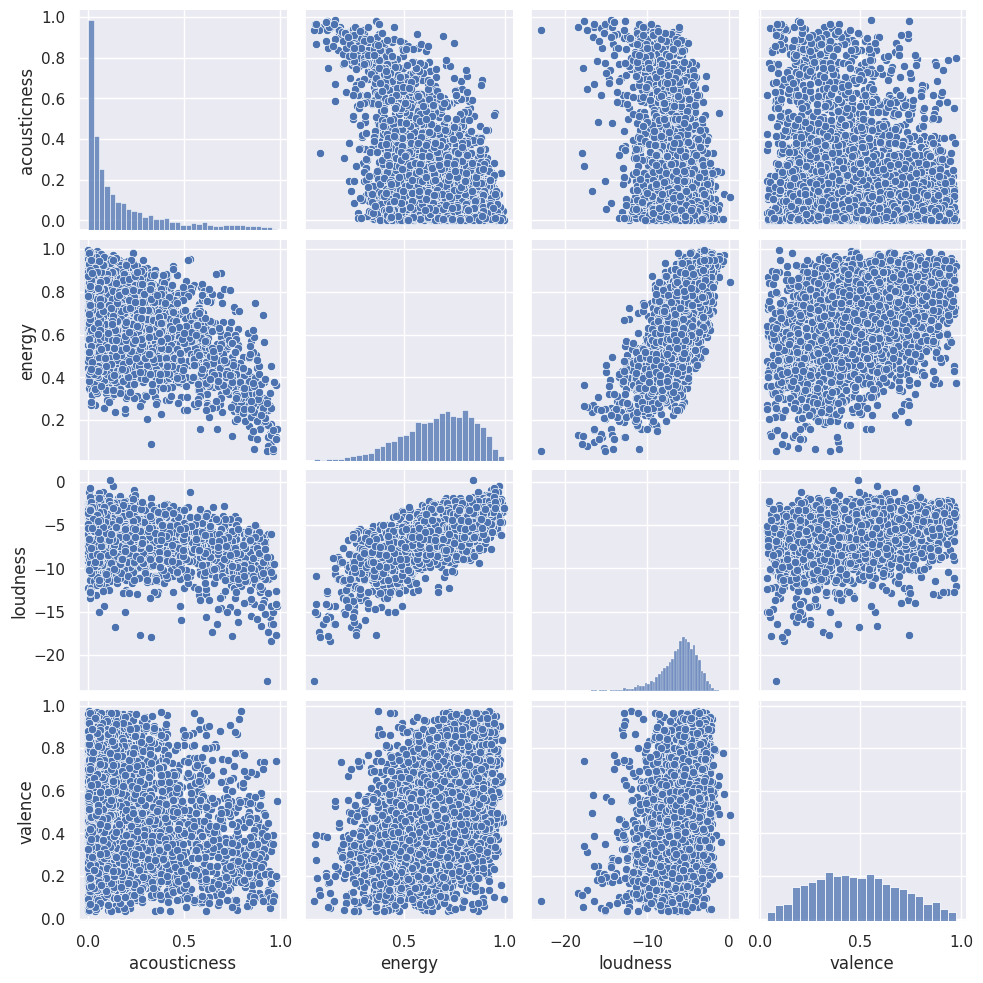

In [13]:
plt.figure(figsize = (10,10))
sns.pairplot(df[['acousticness', 'energy', 'loudness', 'valence']])

### Check distribution of target variable

Very uniform distribution of `highest_position`.

count    4425.000000
mean       50.637514
std        29.557406
min         1.000000
25%        25.000000
50%        52.000000
75%        77.000000
max       100.000000
Name: highest_position, dtype: float64


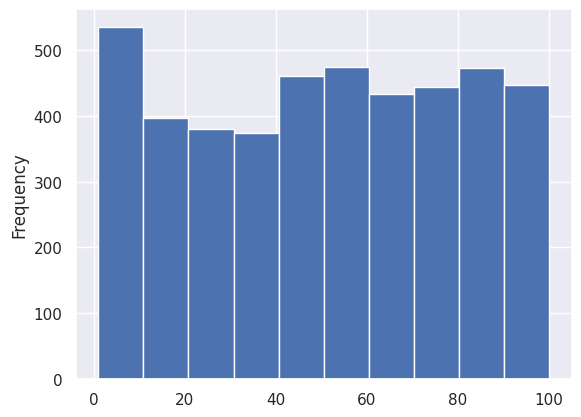

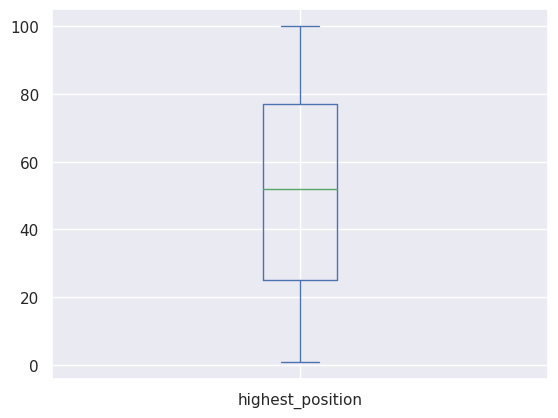

In [ ]:
plt.figure()
df['highest_position'].plot.hist()

plt.figure()
df['highest_position'].plot.box()

print(df['highest_position'].describe())

### Classification labels

Create labels for classification.

Define `highest_quartile` and `high_low` label based on `highest_position`.

- `highest_quartile` = {0, 1, 2, 3}
- `high_low` = {0, 1}

In [39]:
def to_quartile(x):
  if x <= 25:
    return 3
  if x <= 50:
    return 2
  if x <= 75:
    return 1
  return 0

def to_high_low(x):
  if x <= 50:
    return 1
  return 0

df['highest_quartile'] = df['highest_position'].apply(to_quartile)
df['high_low'] = df['highest_position'].apply(to_high_low)

df[['song', 'highest_position', 'highest_quartile', 'high_low']].head()

,song,highest_position,highest_quartile,high_low
0,#Beautiful,15,3,1
1,#SELFIE,16,3,1
2,#thatPOWER,17,3,1
3,$ave Dat Money,71,1,0
4,'Til Summer Comes Around,58,1,0


## Split data

- Split training and testing data.
- Reserve random 25% of samples for testing.
- Remove `targets` from `X` features dataframe.

In [5]:
targets = ['highest_position', 'highest_quartile', 'high_low']
target = 'high_low'
X = df.drop(columns=targets)
y = df[target]

train, test, X_train, X_test, y_train, y_test = train_test_split(df, X, y, test_size=0.25)

print(X_train.shape, y_train.shape)

nonfeatures = ['song_id', 'song', 'performer'] + targets
features = list(filter(lambda x: x not in nonfeatures, features_numeric))

print(features)

(3318, 21) (3318,)
['weeks_on_chart', 'lowest_position', 'spotify_track_duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


## Feature importance

- Learn a full decision tree on all features as a baseline classifier.
- Rank features by importance.

In [74]:
tree = DecisionTreeClassifier()
tree.fit(X_train[features], y_train)

print('score', tree.score(X_test[features], y_test), '\n')

for (feature, importance) in zip(tree.feature_names_in_, tree.feature_importances_):
  print(f'{importance:.03f} {feature}')

score 0.7633242999096658 

0.464 weeks_on_chart
0.146 lowest_position
0.032 spotify_track_duration_ms
0.026 danceability
0.028 energy
0.023 key
0.039 loudness
0.003 mode
0.048 speechiness
0.036 acousticness
0.019 instrumentalness
0.045 liveness
0.046 valence
0.036 tempo
0.008 time_signature


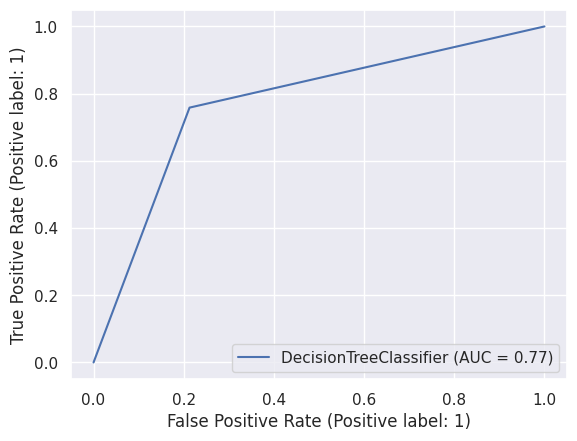

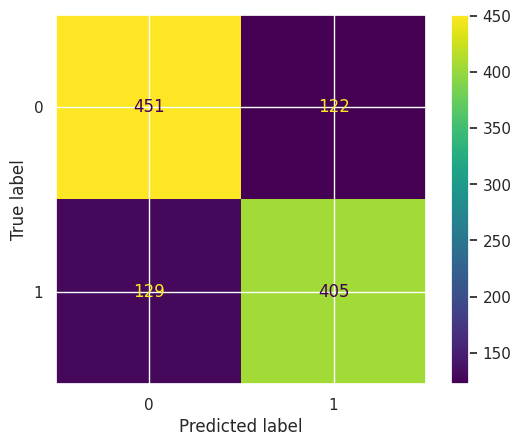

In [56]:
RocCurveDisplay.from_estimator(tree, X_test[features], y_test)
ConfusionMatrixDisplay.from_estimator(tree, X_test[features], y_test)

## Learning

Can a more sophisticated classifier improve on the performance?

Can we do with fewer features?

### SVC

Try SVC with `rbf` kernel. Train only on `weeks_on_chart` and `lowest_position`.

In [59]:
clf_features = tree.feature_names_in_[:2]
print(clf_features)

clf = SVC(kernel='rbf', C=1, gamma=1)
clf.fit(X_train[clf_features], y_train)

print('\nscore', clf.score(X_test[clf_features], y_test))

['weeks_on_chart' 'lowest_position']

score 0.8166214995483289


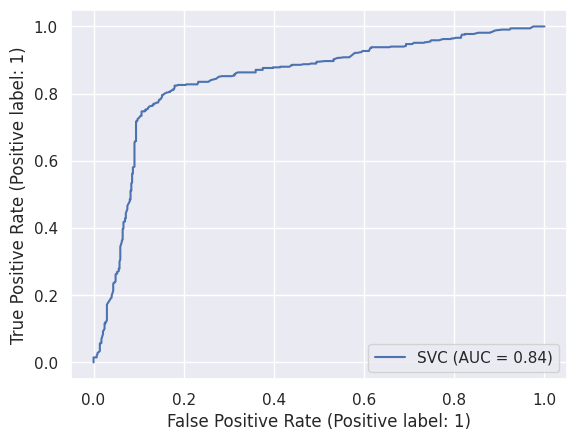

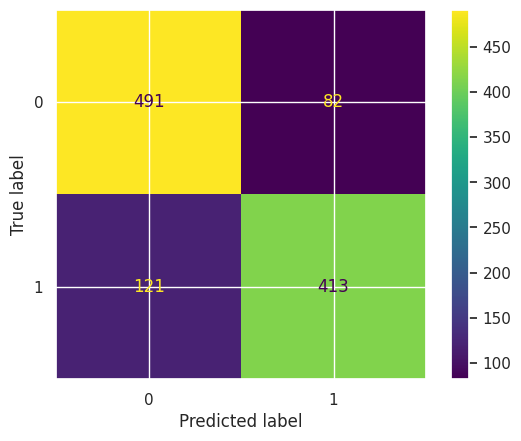

In [60]:
RocCurveDisplay.from_estimator(clf, X_test[clf_features], y_test)
ConfusionMatrixDisplay.from_estimator(clf, X_test[clf_features], y_test)

### Optimize parameters

Grid search to find optimal value for `C` and `gamma`.

We find that SVC performance is very stable across wide range of parameter values.
With the optimal parameter values we achieve a bit more precision.

In [62]:
parameters = {
    'C': np.logspace(-3, 3, base=2, num=7),
    'gamma': np.logspace(-3, 3, base=2, num=7),
}
clf = GridSearchCV(SVC(kernel='rbf'),
                   parameters, cv=3)

grid = clf.fit(X_train[clf_features], y_train)

print(grid.best_score_, grid.best_params_)

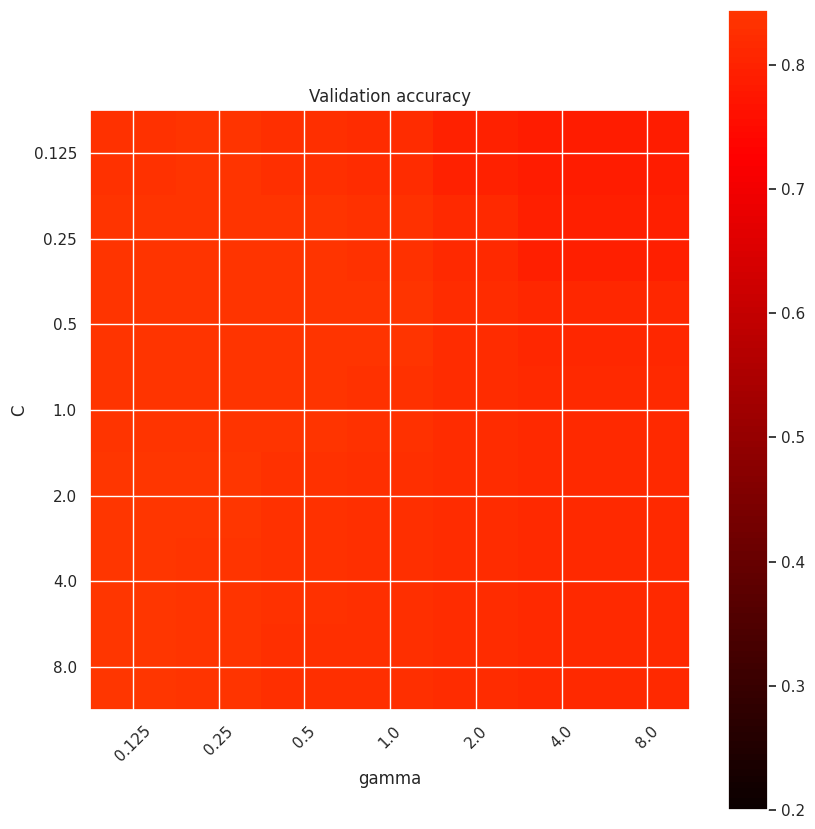

In [66]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plotSearchGrid(grid):
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

plotSearchGrid(grid)

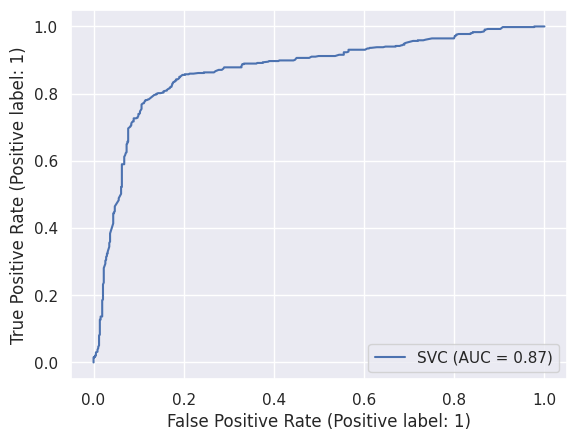

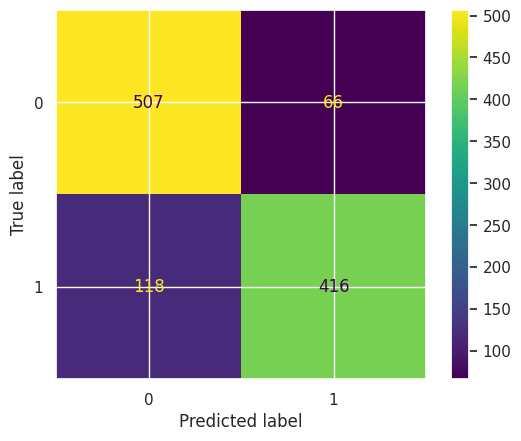

In [65]:
clf = grid.best_estimator_
RocCurveDisplay.from_estimator(clf, X_test[clf_features], y_test)
ConfusionMatrixDisplay.from_estimator(clf, X_test[clf_features], y_test)

## Learning on Audio Features only

The best estimator we found previously used only `weeks_on_chart` and `lowest_position`.

How good performance can we achieve learning only on the audio features?

### Random Forrest

Learn a random forrest classifier over only the audio features of the data.

Using shallow trees (max-depth 1), and limiting features at each split.

We also obtain feature importances.

In [73]:
excluded = ['weeks_on_chart', 'lowest_position']
clf_features = list(filter(lambda x: x not in excluded, features))
print(clf_features)

clf = RandomForestClassifier(n_estimators=1000, max_depth=1, max_features="sqrt")
clf.fit(X_train[clf_features], y_train)

print('\nscore', clf.score(X_test[clf_features], y_test), '\n')

for (feature, importance) in zip(clf.feature_names_in_, clf.feature_importances_):
  print(f'{importance:.03f} {feature}')

['spotify_track_duration_ms', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

score 0.5212285456187895 

0.073 spotify_track_duration_ms
0.221 danceability
0.069 energy
0.012 key
0.064 loudness
0.004 mode
0.055 speechiness
0.145 acousticness
0.054 instrumentalness
0.068 liveness
0.145 valence
0.060 tempo
0.030 time_signature


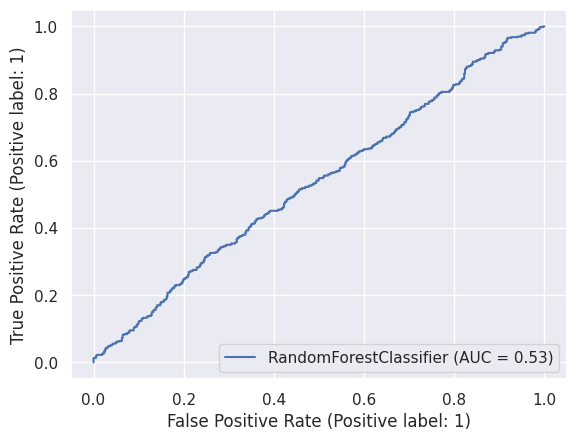

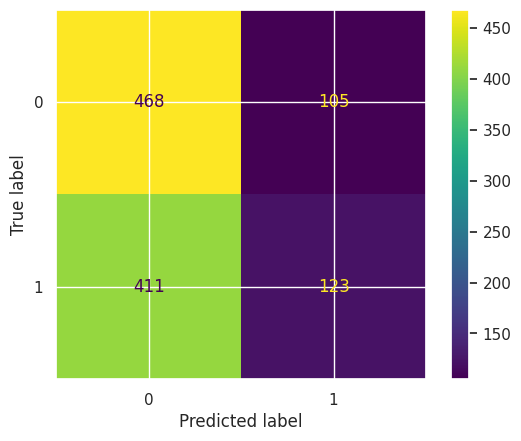

In [71]:
RocCurveDisplay.from_estimator(clf, X_test[clf_features], y_test)
ConfusionMatrixDisplay.from_estimator(clf, X_test[clf_features], y_test)

### Boosting

With random forrest the results are just marginally better than random.

Next we try a boosting classifier.

In [82]:
tree = DecisionTreeClassifier(max_depth=1)
clf = AdaBoostClassifier(tree, n_estimators=2000, learning_rate=0.1)
clf.fit(X_train[clf_features], y_train)

print('score', clf.score(X_test[clf_features], y_test))

score 0.5329719963866305


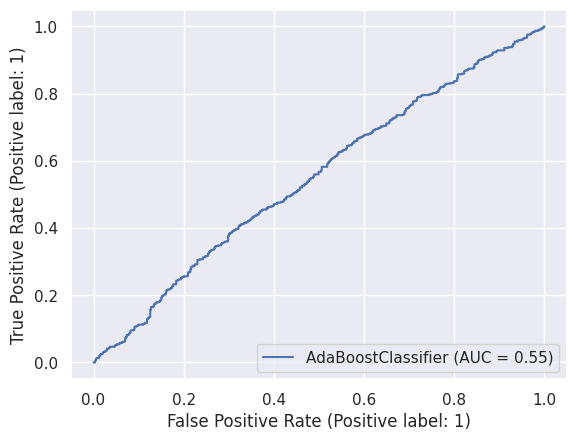

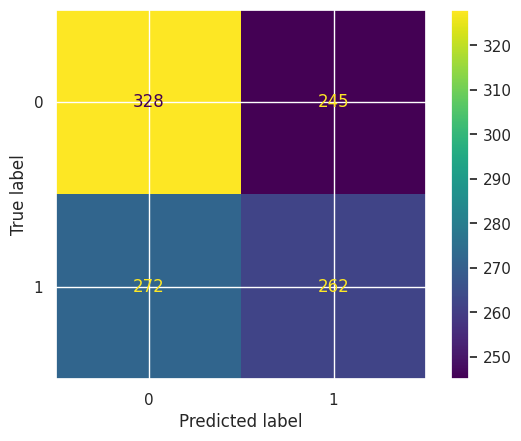

In [83]:
RocCurveDisplay.from_estimator(clf, X_test[clf_features], y_test)
ConfusionMatrixDisplay.from_estimator(clf, X_test[clf_features], y_test)

## Limitations


- We consider a wide range of audio features, but we might be missing some important aspects.
- We have not considered the lyrics content.
- Data from 2010 to 2020 only.
- Audio features from Spotify - possible bias (could sound different on other platforms)


## Conclusion

We cannot learn a good classifier from the audio features only.

But can predict the highest position achieved by a song based on the `lowest_position` (usually the position it enters the chart at) and `weeks_on_chart`.

This suggests a strong momentum effect in song popularity and ranking.

### In general:

**The higher a song enters the billboard chart and the longer it stays on it, the higher position it will reach.**